In [1]:
#since noteboke doesn't work in jupiterlabs    %matplotlib notebook 
%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import os
# os.environ['PATH'] += os.pathsep + 'D:\\6OHDA\\'
import numpy as np
import scipy as sci
from IO import *
from utils import *
import re
from tqdm import tqdm

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Concatenate
from tensorflow.keras.layers import Convolution2D, MaxPooling2D,Conv2D, Conv1D,MaxPooling1D
# from tensorflow.keras.layers.core import Lambda
import tensorflow.keras.optimizers as optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

from matplotlib import pyplot as plt
from matplotlib import gridspec
import seaborn as sns

import pickle
import random
# import png

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
tf.config.list_physical_devices()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1583381928552426010
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10091102208
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2365309020018283368
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:17:00.0, compute capability: 6.1"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 10091102208
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12580944936777772010
physical_device_desc: "device: 1, name: GeForce GTX 1080 Ti, pci bus id: 0000:65:00.0, compute capability: 6.1"
]


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [119]:
Files = ['FinalData_6OHDA.h5','FinalData_6OHDA_H.h5']
miceList = getMiceList(Files[0])
#miceList.remove('1253')
#miceList.remove('1231')
def periodCalc(day):
    if day== 0:
        return 'Healthy'
    elif day<13:
        return 'Acute' #day 1-13
    else:
        return 'Chronic' #day 14-35

In [120]:
mTrain = ['0761', '1208', '1222', '1231', '1236', '7909' , '1793','4539',  '8430','1253']
mValidate = ['2976', '2980', '2981', '7584']
mTest = ['8803', '8815']

In [117]:
# create and save the LFP images so can do flow from directory
savePath = "E:\\data\\HighLow\\"
for g in ['Healthy','Acute','Chronic']:
    if not os.path.isdir(savePath+g):
            os.mkdir(savePath+g)
    sPath = savePath+g+"\\"
    for cond in ['Train','Validate','Test']:
        if not os.path.isdir(sPath+cond):
            os.mkdir(sPath+cond)
            for cond2 in ['high','low']:
                if not os.path.isdir(sPath+cond+'\\'+cond2):
                    os.mkdir(sPath+cond+'\\'+cond2)


In [122]:
from matplotlib import image as pltI
savePath = "E:\\data\\HighLow\\Healthy\\"
dtLp = 0.0032768
tPlot = np.linspace(-1,1,int(2/dtLp-1))
f = h5py.File('D:\\6OHDA\\Spectograms.hdf5','r') 
for g in ['Test']:#['Train','Validate','Test']:
    mList = eval("m"+g)
    sPath = savePath+g+"\\"
    for m in mList:
        data =  getData(Files[0],['lfp','speed'],period ='Pre', mice=m)
        for sess in tqdm(data.keys()):
            if sess[5] == 'B':
                day = 0
            else:
                day = int(re.findall(r'\d+',sess[5:])[0])

            # get data
            period = periodCalc(day)
            if period != 'Healthy':
                continue
            freq = f[m][sess]['Pre']['freq'][:]
            coeff = np.abs(f[m][sess]['Pre']['coeff'][:])
            lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
            coeff[:,(lfpOutliers[:,0]==1)] = np.nan
            Hs = np.nansum(coeff, axis=1)
            coeff = coeff.T/Hs.T
            
            low = getOnsetOrPeriod(m,sess,'Pre','LowMvmtPeriods_vector')
            high = getOnsetOrPeriod(m,sess,'Pre','HighMvmtPeriods_vector')
           
            dtS = 1/data[sess]['speed']['Fs']
            dtL = 1/data[sess]['lfp']['FS']
            ts = np.arange(0, np.max(data[sess]['speed']['speed'].shape)) * dtS 
            tl = np.arange(0, np.max(data[sess]['lfp']['lfp'].shape)) * dtL
            
            for mv in ['low','high']:
                Himvmt = np.full_like(tl,False)
                mVector = eval(mv)
                if np.sum(mVector) == 0:
                    continue
                V = np.append(mVector[1:]*1-mVector[:-1]*1,0)
                HpStart = ts[V==1]
                HpEnd = ts[V==-1]
                if mVector[0] == 1:
                    HpStart = np.insert(HpStart,0,0)
                for segI, seg in enumerate(HpStart):
                    si = np.argmin(np.abs(tl-seg))
                    se = np.argmin(np.abs(tl-HpEnd[segI])
                                  )
                    a = coeff[si:se] 
                    a = sci.signal.decimate(a,10,axis=0)
                    if a.shape[0] < 2436:
                        A = [a]
                    else:
                        A = [a[i : i + 2436,:] for i in range(0, a.shape[0],int(np.ceil(1/dtLp)))] 
                    if g == 'Test':
                        sPathSess = sPath + 'all\\'
                    else:
                        sPathSess = sPath +mv+'\\'
                    for ind,img in enumerate(A):
                        z = (65535*((img - img.min())/img.ptp())).astype(np.uint16)
#                         if z.shape[0] != len(tPlot):
#                             continue
                        pltI.imsave(sPathSess+'{m:s}_{mv:s}_{seg:d}_{ind:d}.png'.format(mv=mv,m=sess,seg=segI,ind=ind), z)
#                         with open(sPathSess+'{m:s}_{seg:d}_{ind:d}.png'.format(m=sess,seg=segI,ind=ind), 'wb') as f2:
#                             f2.write(z)
#                             writer = png.Writer(width=z.shape[1], height=z.shape[0], bitdepth=16, greyscale=True)
#                             zgray2list = z.tolist()
#                             writer.write(f2, zgray2list)
                

                

                


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [02:11<00:00,  9.39s/it]


In [55]:
# f = h5py.File('D:\\6OHDA\\Spectograms.hdf5','r') 
# fig, ax = plt.subplots(1,2)
# # m = '1208'
# sess = '1208_BaselineA'
# data =  getData(Files[0],['lfp','speed'],period ='Pre', mice=m)
# freq = f[m][sess]['Pre']['freq'][:]
# coeff = np.abs(f[m][sess]['Pre']['coeff'][:])
# lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
# coeff[:,(lfpOutliers[:,0]==1)] = np.nan
# coeff = coeff.T

# ax[0].pcolormesh(np.arange(3000),freq,coeff[3000:6000,:].T)
# a = sci.signal.decimate(coeff,10,axis=0)
# ax[1].pcolormesh(np.arange(300),freq,a[300:600,:].T)
# dtL = 0.0032768
# tPlot = np.linspace(-2,2,int(4/dtL-1))
# f.close()
# from PIL import Image
sPath = savePath+g+"\\"
for ind,img in enumerate(A):
    z = (65535*((img - img.min())/img.ptp())).astype(np.uint16)
    print(sPath+'{m:s}_{ind:d}.png'.format(m=m,ind=ind))
    if ind>2:
        break

E:\data\Test\1208_0.png
E:\data\Test\1208_1.png
E:\data\Test\1208_2.png
E:\data\Test\1208_3.png


In [54]:


# fig, ax = plt.subplots(1,1)
# ax.pcolormesh(np.arange(A[0].shape[0]),np.arange(A[0].shape[1]),A[0].T,
#                                 rasterized = True)
# ax.set_aspect('equal', adjustable='box')
# ind=0

with open('E:\\{m:s}_{ind:d}.png'.format(m=m,ind=ind), 'wb') as f:
    writer = png.Writer(width=z.shape[1], height=z.shape[0], bitdepth=16, greyscale=True)
    zgray2list = z.tolist()
    writer.write(f, zgray2list)
# from PIL import Image
# image =  np.array(Image.open('E:\\{m:s}_{ind:d}.png'.format(m=m,ind=ind)))

print(image.shape,z.shape)
np.sum(image!=z)

(1219, 87) (1219, 87)


0

In [422]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    directory="E:\\data\\HighLow\\\Healthy\\Train\\",#'E:\\data\\imageTest\\training_set\\',#
    target_size=(300, 300),
    color_mode="grayscale",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=36
)
validate_generator = valid_datagen.flow_from_directory(
    directory="E:\\data\\HighLow\\\Healthy\\Validate\\",#'E:\\data\\imageTest\\test_set\\',#
    target_size=(300, 300),
    color_mode="grayscale",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42
)
test_generator = test_datagen.flow_from_directory(
    directory="E:\\data\\HighLow\\\Healthy\\Test\\",#'E:\\data\\imageTest\\test_set\\',#
    target_size=(300, 300),
    color_mode="grayscale",
    batch_size=32,
    class_mode=None,
    shuffle=False
)

Found 7486 images belonging to 2 classes.
Found 1078 images belonging to 2 classes.
Found 2091 images belonging to 1 classes.


In [423]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=40,
    mode='max',
    restore_best_weights=True)

In [431]:
# calculate the class weight: - flow from directory goes alphabetically so Acute, Chroniq, Healthy
files_per_class = []
for folder in ['high','low']:
    if not os.path.isfile("E:\\data\\HighLow\\\Healthy\\"+folder):
            files_per_class.append(len(os.listdir("E:\\data\\HighLow\\\Healthy\\Train\\"+folder)))
total_files = sum(files_per_class)
class_weights = {}
for i in range(len(files_per_class)):
    class_weights[i] = 1 - (float(files_per_class[i]) / total_files)
print (class_weights)

{0: 0.5084157093240715, 1: 0.49158429067592835}


In [432]:
print(files_per_class)
for i in range(len(files_per_class)):
    class_weights[i] = (1 /(float(files_per_class[i]))) *( total_files/2)

print(class_weights)

[3680, 3806]
{0: 1.0171195652173912, 1: 0.9834471886495008}


In [427]:
del model

In [428]:
# initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
model = Sequential()
model.add(Conv2D(16, kernel_size=(20,20), activation='relu', input_shape=(300,300,1)))#,kernel_initializer=initializer))
model.add(Conv2D(32, kernel_size=(5,5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(54, kernel_size=(3,3), activation='relu'))

# model.add(Conv2D(64, kernel_size=(5,5), activation='relu'))#,kernel_initializer=initializer))
model.add(Flatten())
# model.add(Dense(50, activation='relu'))#,kernel_initializer=initializer))
model.add(Dense(2, activation='sigmoid'))

In [429]:
print(model.summary())

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 281, 281, 16)      6416      
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 277, 277, 32)      12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 138, 138, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 138, 138, 32)      0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 136, 136, 54)      15606     
_________________________________________________________________
flatten_29 (Flatten)         (None, 998784)            0         
_________________________________________________________________
dense_37 (Dense)             (None, 2)               

In [199]:
for a,b in dataGen(train_generator, butchSize = 32):
    print(a.dtype,b.dtype)
    break

float64 int32


In [433]:
model.compile(optimizer='sgd',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

stepTrain=train_generator.n//train_generator.batch_size
stepValidate=validate_generator.n//validate_generator.batch_size

history = model.fit(train_generator,
                    steps_per_epoch=stepTrain,
                    validation_data=validate_generator,
                    validation_steps=stepValidate,
                    epochs=500,class_weight=class_weights,callbacks=[early_stopping])#,
# history = model.fit(train_generator,class_weight=class_weights,
#                     epochs=4)#,


# print(dataP.shape)
# model.fit(loadData(data))


Epoch 1/500
233/233 [==============================] - 45s 186ms/step - loss: 0.6897 - accuracy: 0.5735 - val_loss: 8.9464 - val_accuracy: 0.6373
Epoch 2/500
233/233 [==============================] - 44s 189ms/step - loss: 0.5901 - accuracy: 0.7008 - val_loss: 9.9508 - val_accuracy: 0.9602
Epoch 3/500
233/233 [==============================] - 43s 184ms/step - loss: 0.4814 - accuracy: 0.7565 - val_loss: 2.4338 - val_accuracy: 0.9470
Epoch 4/500
233/233 [==============================] - 43s 185ms/step - loss: 0.4602 - accuracy: 0.7715 - val_loss: 5.0001 - val_accuracy: 0.9688
Epoch 5/500
233/233 [==============================] - 43s 185ms/step - loss: 0.4408 - accuracy: 0.7823 - val_loss: 6.2140 - val_accuracy: 0.9384
Epoch 6/500
233/233 [==============================] - 43s 185ms/step - loss: 0.4141 - accuracy: 0.8021 - val_loss: 282.3025 - val_accuracy: 0.4148
Epoch 7/500
233/233 [==============================] - 43s 183ms/step - loss: 0.3982 - accuracy: 0.8114 - val_loss: 272.19

In [46]:
a = trainTest(validate_generator)
validate_generator

In [284]:
## Saving the model
# model.save('E:\\caLFP_v1')
# model.save_weights("E:\\caOnly_v1_weights.h5")

INFO:tensorflow:Assets written to: E:\caOnly_v1\assets


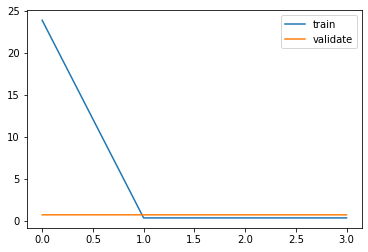

In [69]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='validate')
plt.legend()

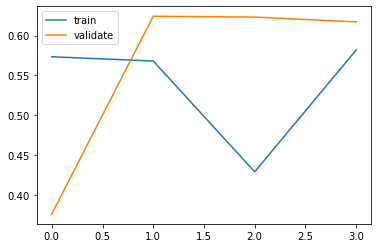

In [65]:
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='validate')
plt.legend()

In [224]:
# x,y = loadTest(data)
score = model.evaluate(train_generator) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])


8000/8000 [==============================] - 26s 3ms/step - loss: 0.6932 - accuracy: 1.0000
Test loss: 0.6931594014167786
Test accuracy: 1.0


In [289]:
del model 
# initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
model = Sequential()
model.add(Conv2D(16, kernel_size=(20,20), activation='relu', input_shape=(300,300,1)))#,kernel_initializer=initializer))
# model.add(Conv2D(32, kernel_size=(300,1), activation='relu'))#,kernel_initializer=initializer))
# model.add(Conv2D(64, kernel_size=(5,5), activation='relu'))#,kernel_initializer=initializer))
model.add(Flatten())
# model.add(Dense(50, activation='relu'))#,kernel_initializer=initializer))
model.add(Dense(2, activation='sigmoid'))

In [330]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
history = model.fit(train_generator, epochs=40,steps_per_epoch=100)

Epoch 1/40
100/100 [==============================] - 8s 73ms/step - loss: 0.2482 - accuracy: 0.8734
Epoch 2/40
100/100 [==============================] - 7s 74ms/step - loss: 0.3959 - accuracy: 0.8666
Epoch 3/40
100/100 [==============================] - 7s 74ms/step - loss: 0.2400 - accuracy: 0.8753
Epoch 4/40
100/100 [==============================] - 7s 73ms/step - loss: 0.2293 - accuracy: 0.8913
Epoch 5/40
100/100 [==============================] - 7s 73ms/step - loss: 0.2095 - accuracy: 0.8978
Epoch 6/40
100/100 [==============================] - 7s 73ms/step - loss: 0.2014 - accuracy: 0.8988
Epoch 7/40
100/100 [==============================] - 7s 74ms/step - loss: 0.2004 - accuracy: 0.9053
Epoch 8/40
100/100 [==============================] - 7s 74ms/step - loss: 0.1875 - accuracy: 0.9106
Epoch 9/40
100/100 [==============================] - 7s 74ms/step - loss: 0.1987 - accuracy: 0.9078
Epoch 10/40
100/100 [==============================] - 7s 74ms/step - loss: 0.1703 - accura

(32, 281, 281, 16)
[0.0000000e+00 1.2665987e-07 2.5480986e-06 ... 1.3967493e+00 1.3975583e+00
 1.3986504e+00] 2265205


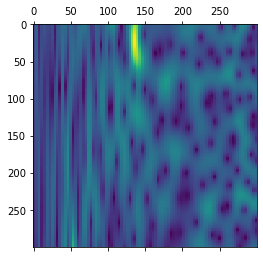

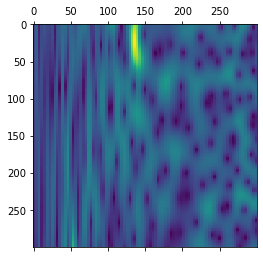

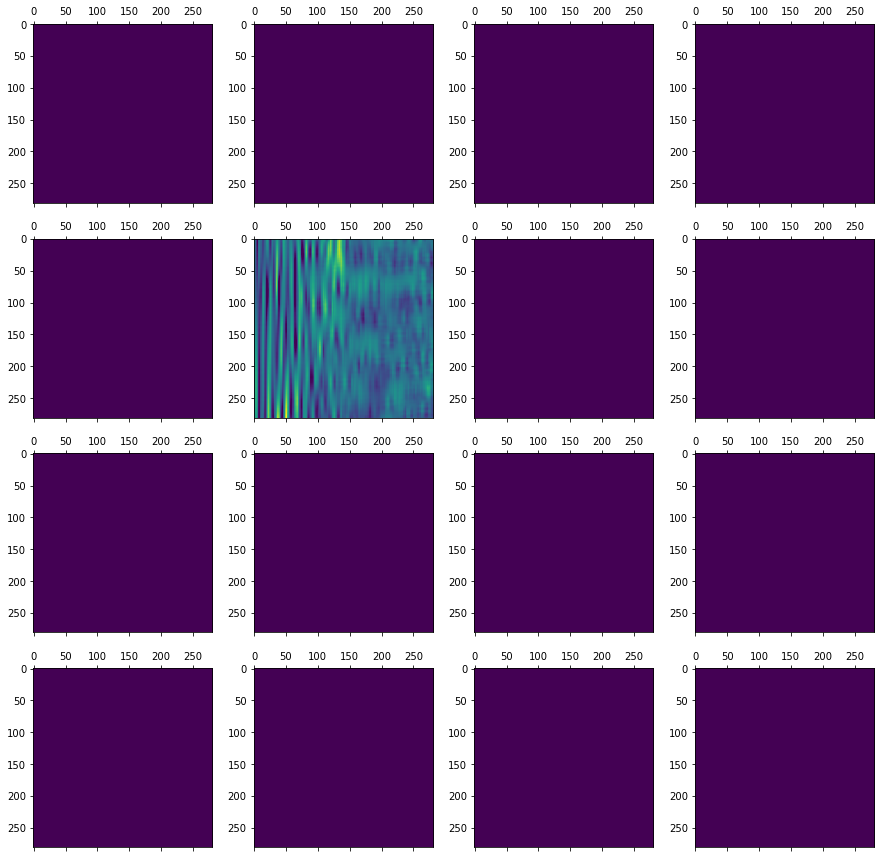

In [434]:
a = test_generator.next()
plt.matshow(a[0,:,:,0], cmap ='viridis')
layer_outputs = [layer.output for layer in model.layers]
activation_model = tf.keras.models.Model(inputs = model.input, outputs = layer_outputs)
# with tf.device('/cpu:0'):
activations = activation_model.predict(a.astype('float32'))
plt.matshow(a[0,:,:,0].astype('float32'), cmap ='viridis')
  
# Getting Activations of first layer
first_layer_activation = activations[0]
  
# shape of first layer activation
print(first_layer_activation.shape)
  
# 6th channel of the image after first layer of convolution is applied
fig, ax = plt.subplots(4,4,figsize=(15.15,15.15))
for c in range(first_layer_activation.shape[3]):
    ax[c//4,c%4].matshow(first_layer_activation[0, :, :, c], cmap ='viridis')
  
# 15th channel of the image after first layer of convolution is applied
# plt.matshow(first_layer_activation[0, :, :, 15], cmap ='viridis')

# # print(inp,a.dtype,a.shape)
print(np.unique(first_layer_activation),len(np.unique(first_layer_activation)))

In [402]:
a

array([[[[0.43529415],
         [0.34901962],
         [0.45882356],
         ...,
         [0.40784317],
         [0.42352945],
         [0.45882356]],

        [[0.454902  ],
         [0.37254903],
         [0.47450984],
         ...,
         [0.43921572],
         [0.44705886],
         [0.45882356]],

        [[0.3921569 ],
         [0.36862746],
         [0.4666667 ],
         ...,
         [0.45882356],
         [0.46274513],
         [0.4431373 ]],

        ...,

        [[0.70980394],
         [0.7176471 ],
         [0.74509805],
         ...,
         [0.16862746],
         [0.16862746],
         [0.15294118]],

        [[0.7137255 ],
         [0.7254902 ],
         [0.75294125],
         ...,
         [0.6862745 ],
         [0.6745098 ],
         [0.6431373 ]],

        [[0.7137255 ],
         [0.7294118 ],
         [0.7568628 ],
         ...,
         [0.6509804 ],
         [0.65882355],
         [0.6392157 ]]],


       [[[0.16862746],
         [0.14509805],
         [0.14

In [394]:
# model =  tf.keras.models.load_model('E:\\caOnly_v1')
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
# model.load_weights("E:\\caOnly_v1_weights.h5")

labels = (train_generator.class_indices)
print(labels)
pred = model.predict(test_generator,verbose=1)
pred2 = np.argmax(pred,axis=1)
print(np.unique(pred2))
print(np.sum(pred2==0),np.sum(pred2==1))
y = []
for f in test_generator.filenames:
    y.append( labels[f.split("\\")[0]])#     print('batch1')

{'cats': 0, 'dogs': 1}
66/66 [==============================] - 9s 144ms/step
[0 1]
1338 753


KeyError: 'all'

In [411]:
f

'cats\\cat.4001.jpg'

In [439]:
# model =  tf.keras.models.load_model('E:\\caOnly_v1')
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
# model.load_weights("E:\\caOnly_v1_weights.h5")

labels = (train_generator.class_indices)
pred = model.predict(test_generator,verbose=1)
pred = np.argmax(pred,axis=1)
print(np.unique(pred))

y = []
for f in test_generator.filenames:
    y.append( labels[f.split("_")[2]])

66/66 [==============================] - 10s 151ms/step
[0 1]


In [85]:
print(trainTest2(test_generator))

<generator object trainTest2 at 0x000002395BCAB350>


2459


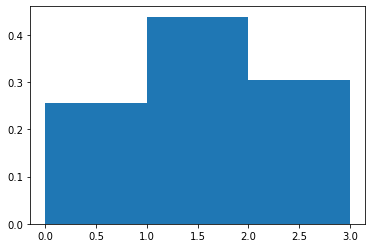

In [131]:
y = []
for ind,(label,dataP) in enumerate(loadTest(dataValidate)):
    y.append(dataP[0])
plt.hist(y,bins=[0,1,2,3],density=True)
print(ind)

In [50]:
print(np.sum(pred==0),np.sum(pred==1))

2087 4


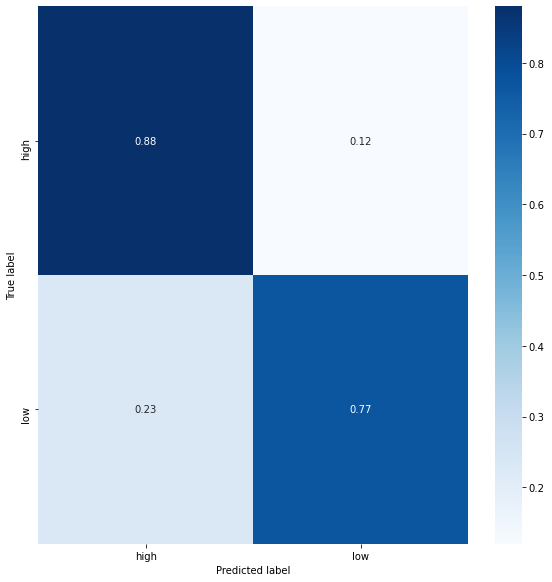

In [440]:
classes=labels.keys()
con_mat = tf.math.confusion_matrix(labels=y, predictions=pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

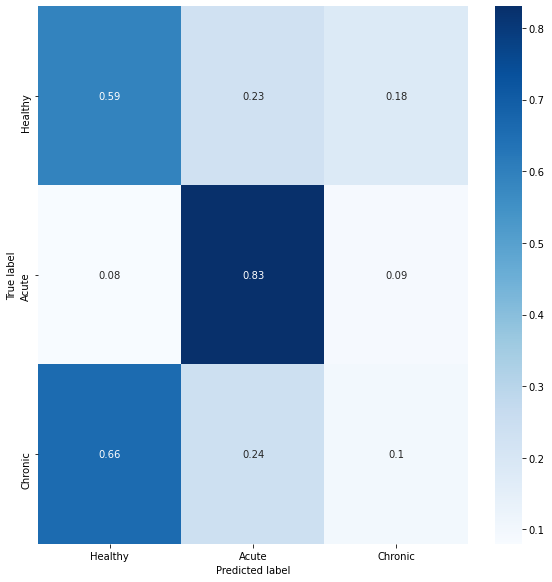

In [290]:
classes=['Healthy','Acute','Chronic']
con_mat = tf.math.confusion_matrix(labels=y, predictions=pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [249]:
# pred = model.predict(loadTest(dataTrain)) 
# print(pred,(sci.special.softmax(pred,axis=1)) )
l

['1793_day8',
 '1222_day7',
 '4539_day15A',
 '1222_BaselineL',
 '1793_BaselineS',
 '7909_day8',
 '1208_day2',
 '8430_day35L',
 '0761_day19L',
 '7909_day10',
 '1236_day30A',
 '1208_BaselineS',
 '1236_day3',
 '1236_day1',
 '4539_day8',
 '1793_day6',
 '1231_BaselineL',
 '0761_day2',
 '8430_day3',
 '1208_BaselineL',
 '0761_day12',
 '4539_day6',
 '7909_day12',
 '1222_day15A',
 '1222_day9',
 '7909_day14',
 '1793_BaselineA',
 '1208_day14',
 '4539_day0',
 '1793_day15A',
 '7909_Baseline2A',
 '0761_BaselineS',
 '0761_day6',
 '1222_day5',
 '1793_day34L',
 '1222_day20L',
 '1208_day30A',
 '0761_day4',
 '1222_day3',
 '0761_day1',
 '1222_day32A',
 '1253_BaselineS',
 '1793_day12',
 '8430_day9',
 '4539_day14',
 '7909_day13',
 '1231_BaselineA',
 '1222_day2',
 '1793_day2',
 '0761_day31A',
 '4539_day12',
 '1793_day14',
 '8430_day19L',
 '7909_day0',
 '8430_day11',
 '1236_day35L',
 '1236_day9',
 '1208_day15A',
 '8430_BaselineS',
 '8430_BaselineL',
 '0761_day8',
 '1208_day12',
 '1236_day13',
 '8430_day5',
 '